# Assignment 1 MTA Subway Timeseries

yg833

This problem set was quite long. I worked with a number of colleagues from class - QY (qg412), Jerome (jl9489), Andrea(ah4412), Fekade Brook (fb1182), and Sam (sjf374). Mainly, we worked alongside each other thinking out loud and comparing outputs.

# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.


# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


# Task 3: 
## Build a classifier that assigns a card type to a time series based on time series features


Populating the interactive namespace from numpy and matplotlib


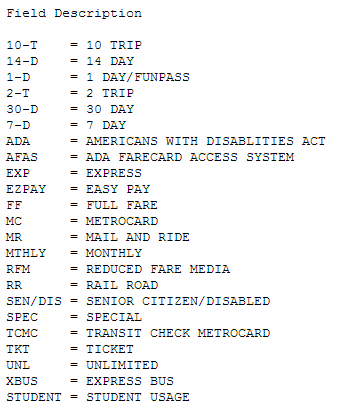

In [2]:
# set up libraries
from __future__ import print_function, division

import os
import sys
import urllib
import io

import pylab as pl
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

In [3]:
# setting environmental variable
os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")
print(os.environ["PUIDATA"])

/nfshome/yg833/PUIdata


In [4]:
# url for mta fare data
url = 'https://github.com/fedhere/PUI2018_fb55/raw/master/HW11_fb55/MTA_Fare.npy' 

# retrieve csv file from the url
urllib.request.urlretrieve(url, 'MTA_Fare.npy')

('MTA_Fare.npy', <http.client.HTTPMessage at 0x7f670bc3cd30>)

In [5]:
# move the file to PUIData folder
!mv MTA_Fare.npy $PUIDATA

In [6]:
mta = np.load(os.environ["PUIDATA"]+'/MTA_Fare.npy')

In [7]:
shape(mta)

(600, 23, 194)

This is the information I recieved about the data: "each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

** note that the missing values are inputted as -1**

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

# read in data as instructed above

In [8]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


create a "ride types" list based on the metadata I was given

In [9]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


You need to create a date range to plot properly. 
After that I create a date range (for example with pd.date_range())
in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
all time series, each station each ride type, look like this (pretty ugly)

Text(0.5, 1.0, 'All MTA Stations and All Ride Types For 194 Weeks from May 19th, 2010')

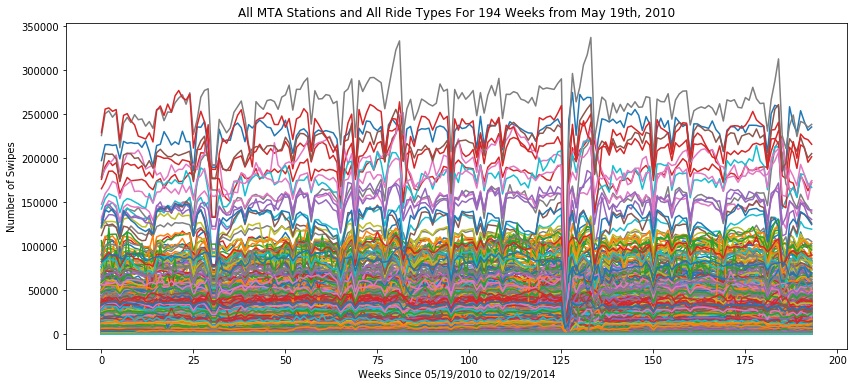

In [10]:
# plot the data in natural space
# then plot the  data in log space (may take a while to plot because of the very inefficient double for loop - 
# the counter needs to get to 23)

pl.figure(figsize(14,6))

for i in range(len(mta)):
    for j in range(len(mta[i])):
        pl.plot(mta[i,j])

pl.xlabel('Weeks Since 05/19/2010 to 02/19/2014')
pl.ylabel('Number of Swipes')
pl.title('All MTA Stations and All Ride Types For 194 Weeks from May 19th, 2010')

### Figure 1: Plot of mta swipes data with x axis as weeks between 05/19/2010 and 02/19/2014. The plot is very messy and kind of hard to read. There appears to be many dips at around (all approximate reads of the x-axis) week 27, week 70, week 90, week 127, week 150 and so on. The obvious valleys were around week 80 and week 130.  

In [11]:
# convert the mta cube with -1s  into float and convert to nans
mta = mta[:].astype(float)

/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


Text(0.5, 1.0, 'All MTA Stations and All Ride Types For 194 Weeks from May 19th, 2010 in Semi Log Scale')

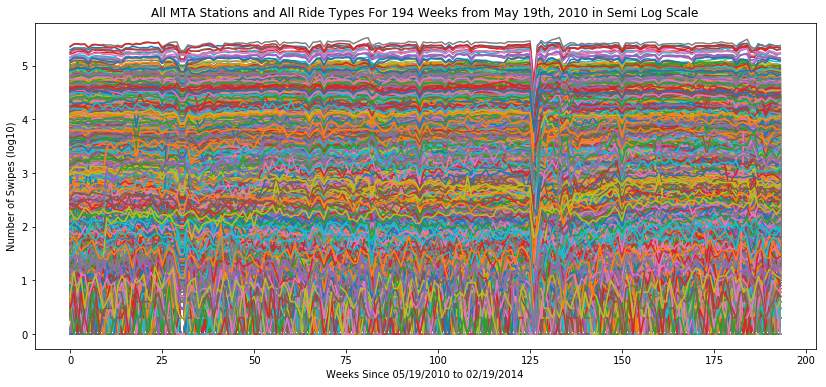

In [12]:
# then plot the  data in log space (may take a while to plot because of the very inefficient double for loop - 
# the counter needs to get to 23)

pl.figure(figsize(14,6))

for i in range(len(mta)):
    for j in range(len(mta[i])):
        pl.plot(np.log10(mta[i,j]))

pl.xlabel('Weeks Since 05/19/2010 to 02/19/2014')
pl.ylabel('Number of Swipes (log10)')
pl.title('All MTA Stations and All Ride Types For 194 Weeks from May 19th, 2010 in Semi Log Scale')

### Figure 2: Time series for all rides types and all stations in semi-log space. The plot is still kind of messy still but easier to read than compared to the one in Figure 1. From this second plot, it seems like the dip was at around week 125. 

In [13]:
dates_studied = pd.date_range(start = '2010/05/19', periods=194, freq='W-WED') # creats a date range for this analysis

/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


Text(0.5, 1.0, 'All MTA Stations and All Ride Types For 194 Weeks from May 19th, 2010 in Semi Log Scale')

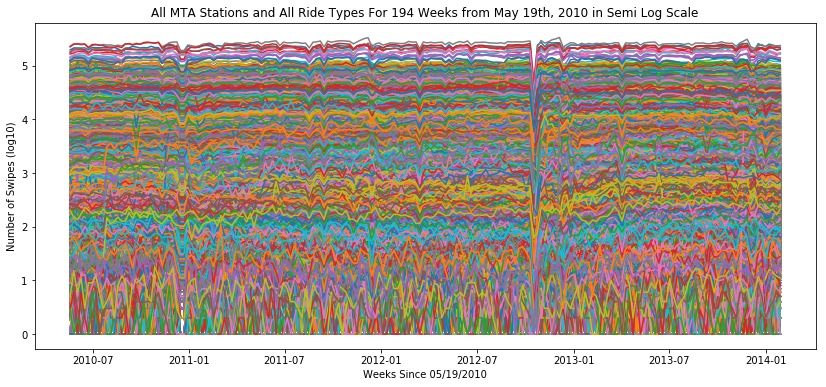

In [14]:
# then plot the  data in log space (may take a while to plot because of the very inefficient double for loop - 
# the counter needs to get to 23)

pl.figure(figsize(14,6))

for i in range(len(mta)):
    for j in range(len(mta[i])):
        pl.plot(dates_studied,np.log10(mta[i,j]))

pl.xlabel('Weeks Since 05/19/2010')
pl.ylabel('Number of Swipes (log10)')
pl.title('All MTA Stations and All Ride Types For 194 Weeks from May 19th, 2010 in Semi Log Scale')

### Figure 3: Same as figure 2 but changing the x-axis to read the date of week instead of the week number.

# 1: event detection 

## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Find the date and see what  may have caused this event 


In [15]:
# define point of change function from Dr. Bianco's repo
# Dr. Bianco's code
##single point change detector
# as in https://www.slideshare.net/FrankKelly3/changepoint-detection-with-bayesian-inference
# with modifications for efficiency

def changeFinder(data):

    n = len(data)
    datamean = np.nanmean(data)
    datasqmean = np.nanmean(data**2)
    fac = datasqmean - datamean**2
    
    datacsum = np.nancumsum(data)
    datasum = datacsum[-1]

    ppoc = np.zeros(n) #container for point of change relative prob

    #online (iterative) search for point of change
    for m in range(n-1):
        pos = m + 1
        relativePosition = (pos) * (n - pos)
 
        Q = datacsum[m] - (datasum - datacsum[m]) #cumsum up to m - cumsum after
        
        U = -(datamean * (n - 2 * pos) + Q)**2 / (4.0 * relativePosition) + fac
       
        ppoc[m+1] = (-(n * 0.5 - 1) * np.log(n * U * 0.5) - 
                 0.5 * np.log(relativePosition))

    ppoc[0] = min(ppoc[1:])
    changePoint = np.argmax(ppoc)
    
    return {'pChange': ppoc, 
            'pointOfChange': changePoint + 1,
            'meanBefore': np.nanmean(data[:changePoint+1]), 
            'meanAfter': np.nanmean(data[(changePoint+1):])}

In [16]:
# using the change finder function to find the point of change.
ppoc = changeFinder(mta[0][0])

In [17]:
dates_studied[ppoc['pointOfChange']]

Timestamp('2012-10-24 00:00:00', freq='W-WED')

#### From the point of change function, it looks like that it happened in week 127. So I looked up week 127 from the date range and saw that it correlates to the week of October 24th, 2012

In [18]:
## flatten the dataframe to sum over the wipes per station per week
mta_sum_by_card_types = np.nansum(mta, axis = 0)
mta_sum_by_wk = np.nansum(mta_sum_by_card_types, axis = 0)

In [19]:
shape(mta_sum_by_wk)

(194,)

In [20]:
print ("mean swipes by week {:.2f}".format(mta_sum_by_wk.mean()))
print ("stdev swipes by week {:.2f}".format(mta_sum_by_wk.std()))
thresholds = [mta_sum_by_wk.mean() + 3 * mta_sum_by_wk.std(), 
              mta_sum_by_wk.mean() - 3 * mta_sum_by_wk.std()]
print ("3-sigma thresholds {:.2f} {:.2f}".format(*thresholds))


mean swipes by week 29778001.61
stdev swipes by week 2984034.35
3-sigma thresholds 38730104.65 20825898.56


In [21]:
thresholds

[38730104.651779145, 20825898.5647157]

In [22]:
mta_sum_by_wk = pd.DataFrame(mta_sum_by_wk, columns=['sum_swipes_weekly'])
mta_sum_by_wk['week_of'] = dates_studied

In [23]:
mta_sum_by_wk.head()

sum_swipes_weekly    week_of
0         26716631.0 2010-05-19
1         29262313.0 2010-05-26
2         29597575.0 2010-06-02
3         29383978.0 2010-06-09
4         29182176.0 2010-06-16

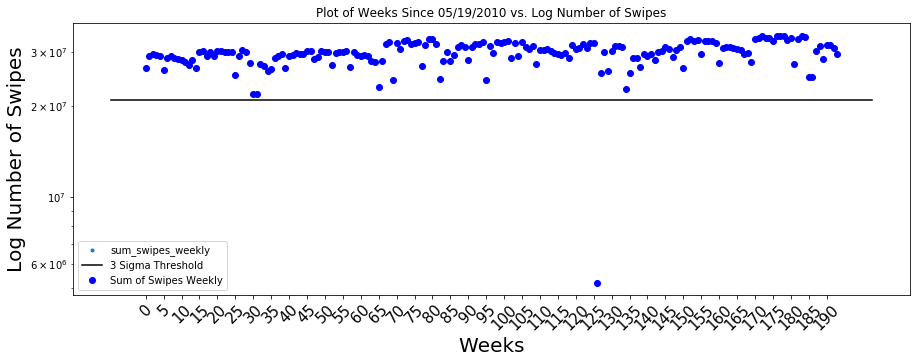

In [24]:
# this was adapted from dr. bianco's FDNYdeaths notebook
ax = mta_sum_by_wk['sum_swipes_weekly'].plot(logy=True, figsize=(15,5), style=".")
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[1], thresholds[1]], color='k', label = '3 Sigma Threshold')
pl.plot(mta_sum_by_wk['sum_swipes_weekly'], 'bo', label = 'Sum of Swipes Weekly')
pl.xticks(np.arange(0, 195, step=5), rotation=45, fontsize=15)
pl.yticks(fontsize=10)
pl.ylabel("Log Number of Swipes", fontsize=20)
pl.xlabel("Weeks", fontsize=20)
pl.title("Plot of Weeks Since 05/19/2010 vs. Log Number of Swipes")
pl.legend(loc = 3)

### Figure 4: Looking at the plot above it looks like that around week 125, there is an event which is > 3 sigmas from the whole time series. Finding that value in the array, it is at around week 127 with 5215466 swipes total that week.

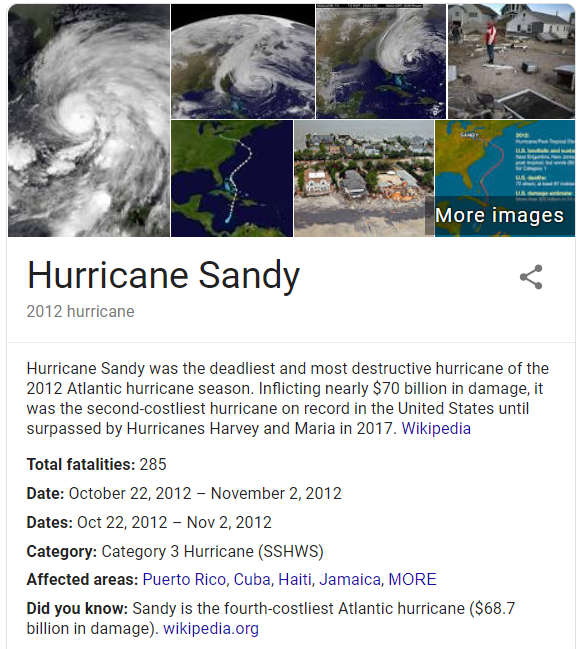

In [25]:
Image(filename = "Sandy.PNG")

 # 2: finding trends
 

## NOTE ON THE TREND DETECTION:
### you should find the *ride type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series


In [26]:
## flatten the dataframe to take the mean over the swipes per station per weeks
mta_mean_by_card_types = np.nanmean(mta, axis = 0)
shape(mta_mean_by_card_types)

(23, 194)

In [27]:
mta_mean_by_card_types_df = pd.DataFrame(mta_mean_by_card_types,
                                         index = ridetype).T # transpose the matrix

In [28]:
mta_mean_by_card_types_df.head(5) # just to see if the df looks right

10t         14d         1d          2t         30d           7d  \
0  19157.461667  883.976667  79.438333  310.688333   77.783333  6162.175000   
1  20877.866667  972.323333  85.578333  331.816667  107.023333  6636.115000   
2  21277.483333  976.761667  85.831667  332.551667   94.761667  6721.488333   
3  21089.230000  937.441667  86.543333  327.086667   62.153333  6721.026667   
4  21349.263333  914.536667  85.028333  324.578333   58.456667  6542.183333   

            ada       afas         exp           ez  ...        month  \
0  14252.998333  16.541667  555.098333   853.156667  ...   204.993333   
1  15810.425000  19.513333  471.026667   963.140000  ...   253.015000   
2  15794.001667  20.233333  503.151667  1025.666667  ...   252.335000   
3  15749.906667  18.473333  508.960000  1010.221667  ...   244.928333   
4  15489.776667  17.298333  559.406667   938.850000  ...   229.586667   

           rfm          rr        sen      spec        tcmc          t  \
0  1316.620000   99.451667  46.805000 -0.230000  207.591667  34.870000   
1  1513.215000  115.116667  53.656667 -0.231667  202.623333  35.885000   
2  1523.311667  115.728333  54.135000 -0.228333  203.406667  35.493333   
3  1504.020000  113.270000  53.778333 -0.228333  203.190000  35.821667   
4  1425.728333  110.401667  52.995000  0.066667  199.400000  33.601667   

       umlim      xbus  stud  
0   9.983333  0.366667  -1.0  
1   9.968333  0.558333  -1.0  
2  10.588333  0.546667  -1.0  
3  10.755000  0.578333  -1.0  
4  10.295000  0.526667  -1.0  

[5 rows x 23 columns]

In [29]:
mta_mean_by_card_types_df.describe()

10t          14d          1d          2t         30d  \
count    194.000000   194.000000  194.000000  194.000000  194.000000   
mean   22070.390584  1046.286856   93.621091  311.779983   80.698600   
std     2026.077147   151.441907   12.700442   29.395951   21.111733   
min     3885.976667   176.598333   16.771667   57.933333    1.880000   
25%    21108.278750   964.359583   85.125833  300.909583   66.857917   
50%    22444.884167  1043.571667   95.264167  318.635833   84.365000   
75%    23225.690000  1140.231667  103.779583  329.686667   98.191667   
max    25513.598333  1340.536667  114.018333  344.535000  114.033333   

                 7d           ada        afas         exp           ez  \
count    194.000000    194.000000  194.000000  194.000000   194.000000   
mean    7990.859708  14930.571246    2.912552   80.950533   165.448419   
std     1275.040088   1760.292817    6.789240  185.269564   369.796708   
min     1687.903333   2603.810000   -0.270000   -0.270000    -0.270000   
25%     7080.735000  14137.473750   -0.228333   -0.226667    -0.228333   
50%     7912.727500  15391.055000   -0.226667   -0.223333    -0.225000   
75%     8754.674583  16103.334583   -0.223333   -0.218750    -0.221667   
max    10769.331667  16909.146667   21.098333  607.043333  1282.683333   

          ...            month          rfm          rr         sen  \
count     ...       194.000000   194.000000  194.000000  194.000000   
mean      ...       179.598995   870.664888  203.213582  108.527105   
std       ...        39.674391   286.202880   63.847896   34.616250   
min       ...         4.773333   103.086667   30.183333   19.658333   
25%       ...       158.014583   686.352083  154.700000   84.317500   
50%       ...       175.488333   741.320000  207.215000  112.381667   
75%       ...       205.549167   950.630000  254.860000  135.537917   
max       ...       253.015000  1571.903333  334.500000  176.111667   

             spec        tcmc           t       umlim        xbus         stud  
count  194.000000  194.000000  194.000000  194.000000  194.000000   194.000000  
mean    45.713308  253.635808   35.726460   10.390799    1.099356   849.578986  
std     20.173107   58.294213    4.891283    1.701547    0.505026  1115.785862  
min     -0.231667   66.695000    8.348333    2.775000   -0.230000    -1.000000  
25%     26.509167  212.809583   34.742500    9.574583    0.657083    -1.000000  
50%     52.983333  242.220833   36.768333   10.418333    1.186667    -0.230000  
75%     60.970833  285.041667   39.068750   11.399167    1.517917  2177.305833  
max     82.853333  402.733333   41.281667   13.711667    2.038333  2657.383333  

[8 rows x 23 columns]

Text(0.5, 1.0, 'All MTA Stations and Card Type For 194 Weeks from May 19th, 2010')

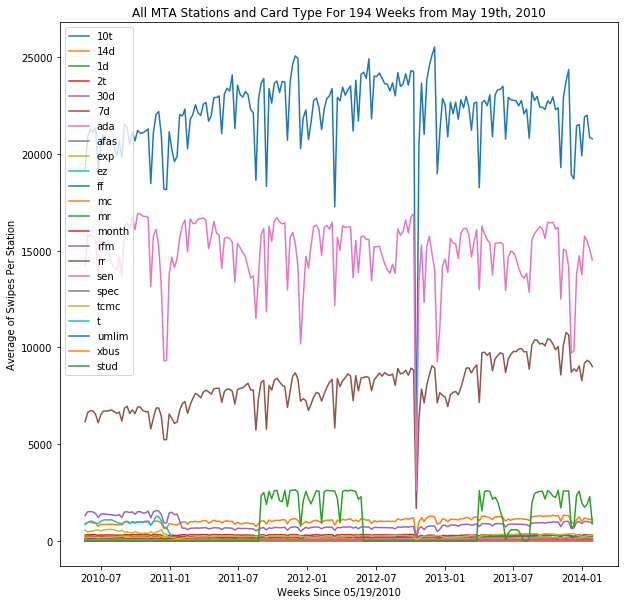

In [30]:
pl.figure(figsize(10,10))

for i in ridetype:
    pl.plot(dates_studied, mta_mean_by_card_types_df[i])
pl.xlabel('Weeks Since 05/19/2010')
pl.ylabel('Average of Swipes Per Station')
pl.legend(loc = 0)
pl.title('All MTA Stations and Card Type For 194 Weeks from May 19th, 2010')

### Figure 5: Plot of the Weeks Since 05/19/2010 vs Average Swipes Per Station For each Card Type

In [31]:
mta_rolling_mean_by_card_types_df = mta_mean_by_card_types_df.rolling(20, min_periods=5).mean()

In [32]:
mta_rolling_mean_by_card_types_df.head()

10t      14d      1d          2t        30d           7d  \
0        NaN      NaN     NaN         NaN        NaN          NaN   
1        NaN      NaN     NaN         NaN        NaN          NaN   
2        NaN      NaN     NaN         NaN        NaN          NaN   
3        NaN      NaN     NaN         NaN        NaN          NaN   
4  20750.261  937.008  84.484  325.344333  80.035667  6556.597667   

            ada    afas         exp       ez  ...        month       rfm  \
0           NaN     NaN         NaN      NaN  ...          NaN       NaN   
1           NaN     NaN         NaN      NaN  ...          NaN       NaN   
2           NaN     NaN         NaN      NaN  ...          NaN       NaN   
3           NaN     NaN         NaN      NaN  ...          NaN       NaN   
4  15419.421667  18.412  519.528667  958.207  ...   236.971667  1456.579   

           rr     sen      spec        tcmc          t   umlim      xbus  stud  
0         NaN     NaN       NaN         NaN        NaN     NaN       NaN   NaN  
1         NaN     NaN       NaN         NaN        NaN     NaN       NaN   NaN  
2         NaN     NaN       NaN         NaN        NaN     NaN       NaN   NaN  
3         NaN     NaN       NaN         NaN        NaN     NaN       NaN   NaN  
4  110.793667  52.274 -0.170333  203.242333  35.134333  10.318  0.515333  -1.0  

[5 rows x 23 columns]

/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


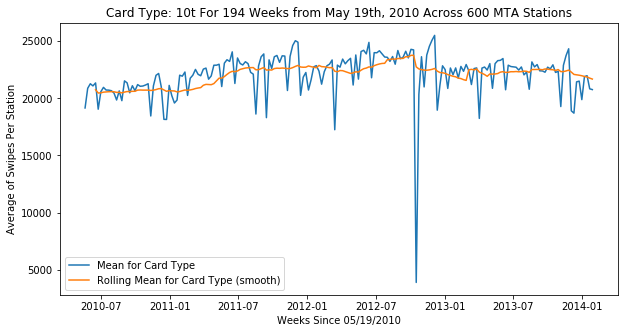

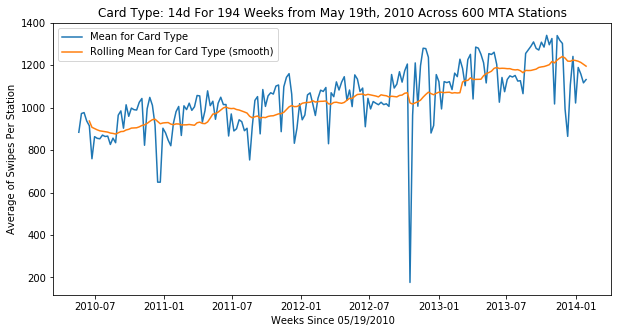

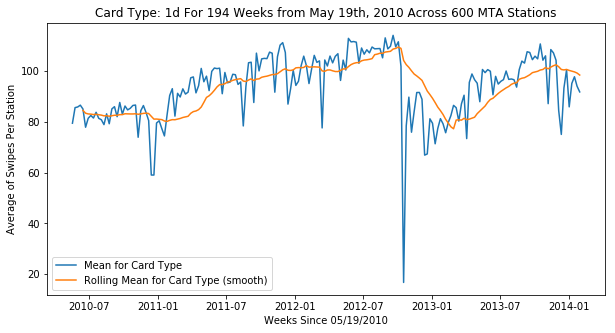

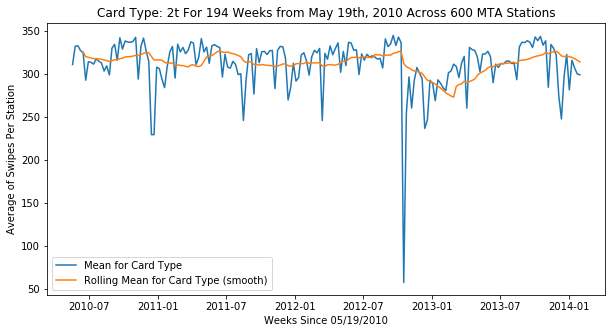

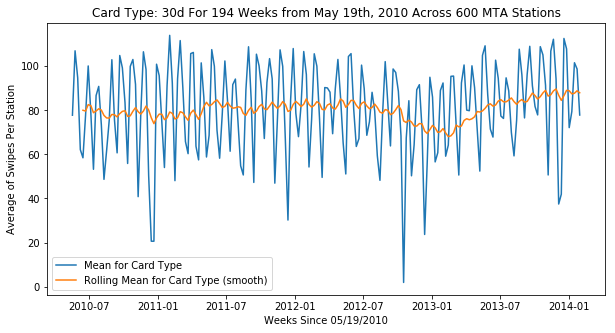

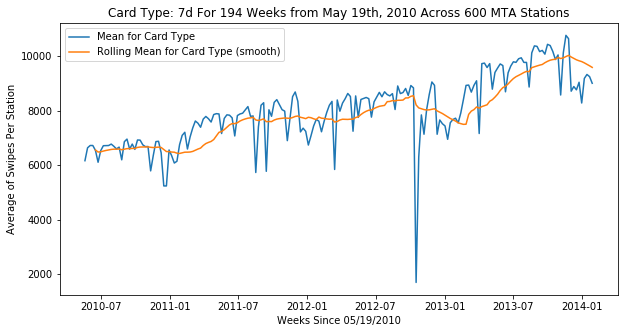

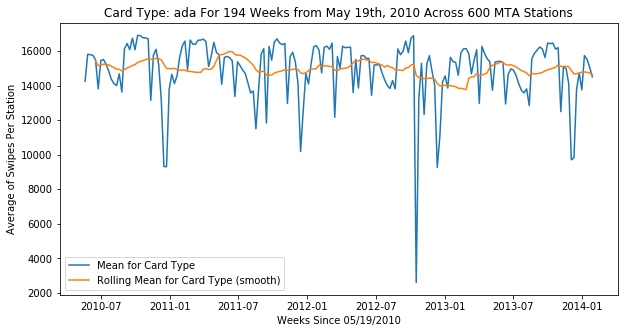

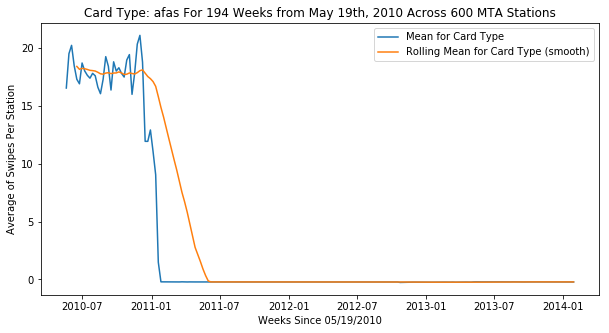

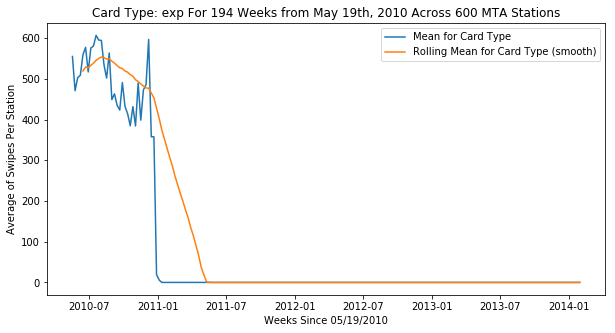

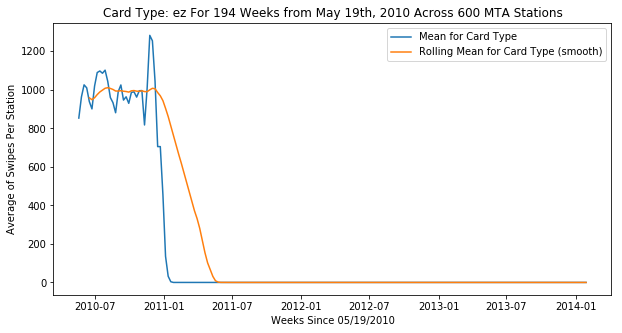

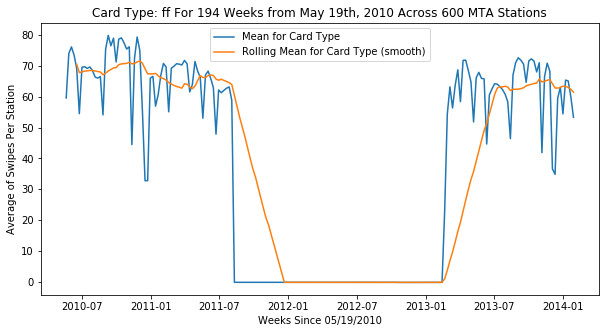

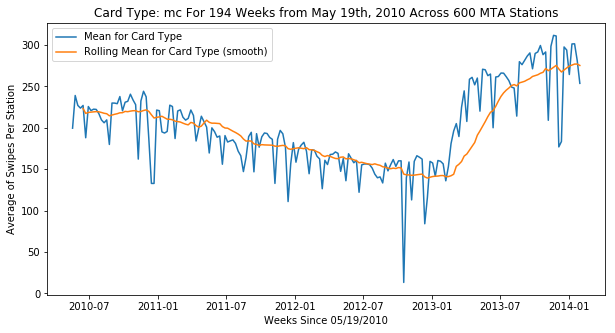

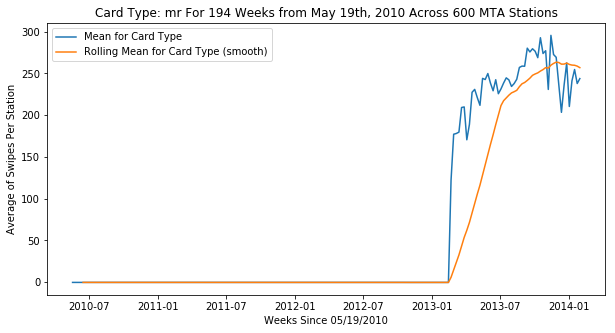

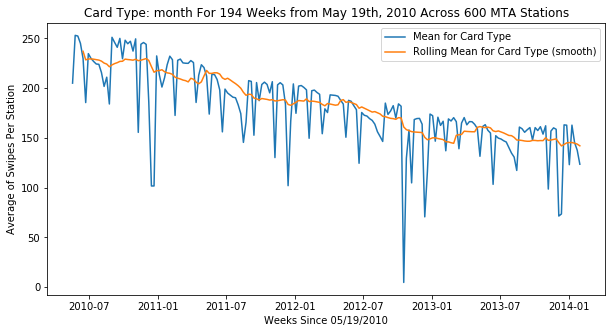

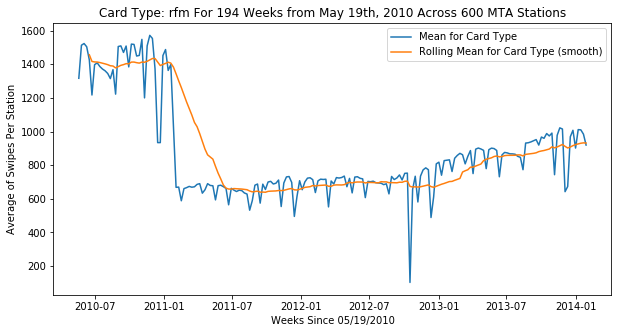

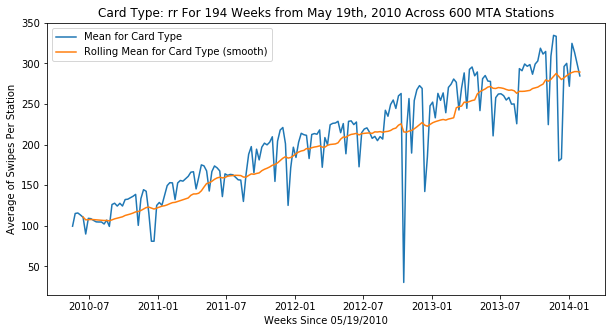

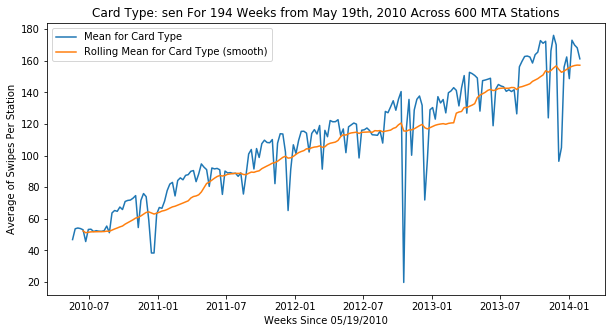

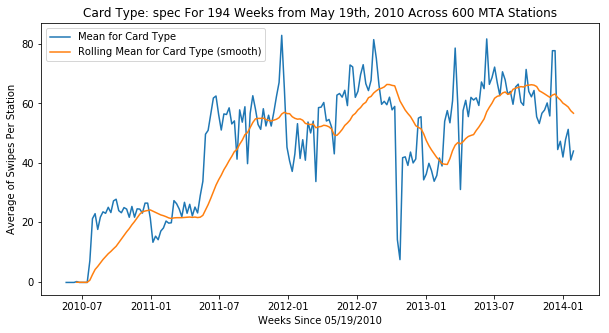

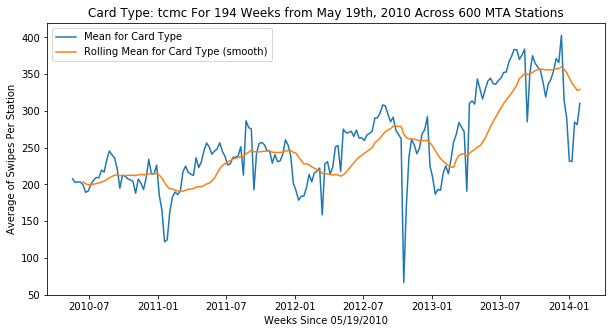

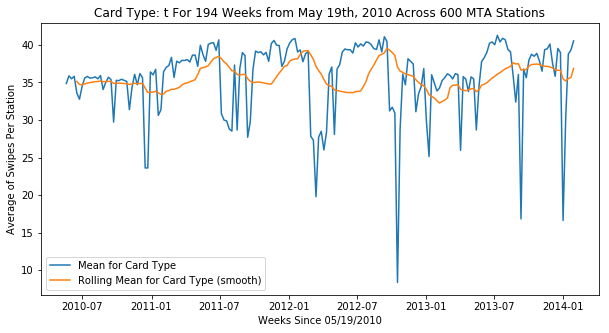

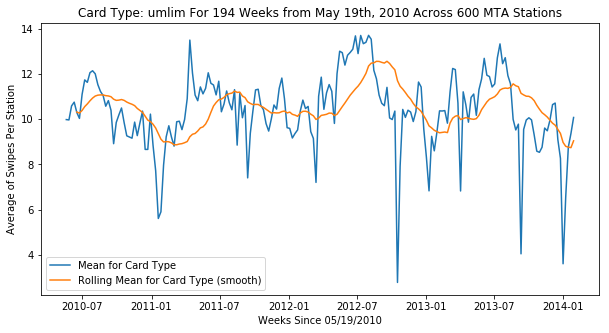

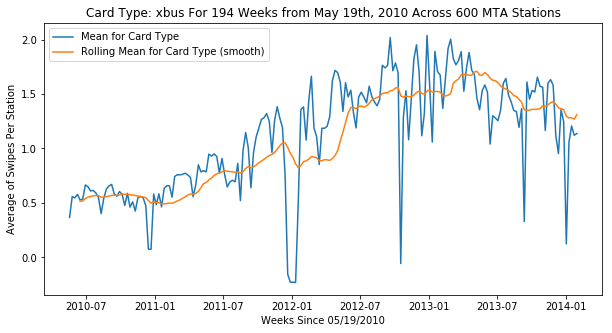

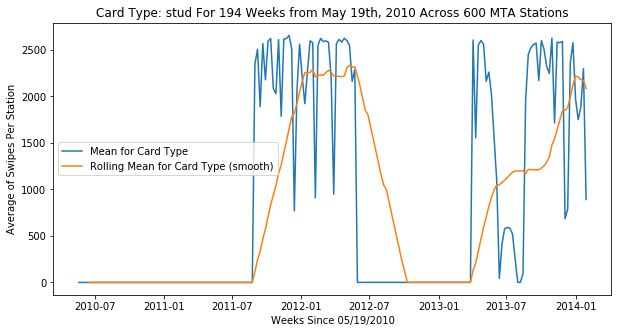

In [33]:
for i in ridetype:
    pl.figure(figsize(10,5))
    pl.plot(dates_studied, mta_mean_by_card_types_df[i], label = 'Mean for Card Type')
    pl.plot(dates_studied, mta_rolling_mean_by_card_types_df[i], label = 'Rolling Mean for Card Type (smooth)')
    pl.xlabel('Weeks Since 05/19/2010')
    pl.ylabel('Average of Swipes Per Station')
    pl.legend(loc = 0)
    pl.title('Card Type: '+ i + ' For 194 Weeks from May 19th, 2010 Across 600 MTA Stations')

### Figure 6: 23 Individual Plots for Each Card Type where both the means and the rolling means are graphed. The *blue* lines are showing the means and the *orange* lines are showing the rolling means. From the plots above it looks like there are some card types that have experienced increases and some that have experienced declines. 

* Increases:
    *14d (1)
    *7d (5)
    *mc (11)
    *mr (12)
    *rr (15)
    *sen (16)
    *spec (17)
    *tcmc (18)
    
* Declines:
    *afas (7)
    *exp (8)
    *ez (9)
    *month (13)
    *rfm (14)

In [34]:
first_ten = mta_mean_by_card_types_df.iloc[0:10,:].sum()

In [35]:
last_ten = mta_mean_by_card_types_df.iloc[184:194, :].sum()

In [36]:
card_stdev = np.std(mta_mean_by_card_types_df)

In [37]:
diff_first_last = last_ten - first_ten

In [38]:
ratio_change = (diff_first_last/ first_ten)

In [39]:
res_ratio = pd.concat([first_ten, last_ten,card_stdev, diff_first_last, ratio_change], 
                      axis=1, 
                      sort=False)

res_ratio.columns = ['first_ten', 'last_ten', 'card_stdev','diff_first_last', 'ratio_change']

In [40]:
res_ratio

first_ten       last_ten   card_stdev  diff_first_last  \
10t    205786.481667  210272.240000  2020.848552      4485.758333   
14d      8887.316667   11128.065000   151.051089      2240.748333   
1d        829.361667     921.951667    12.667666        92.590000   
2t       3174.838333    2964.513333    29.320090      -210.325000   
30d       796.983333     823.978333    21.057251        26.995000   
7d      65569.440000   91125.853333  1271.749657     25556.413333   
ada    151957.233333  136737.161667  1755.750118    -15220.071667   
afas      180.735000      -2.258333     6.771719      -182.993333   
exp      5456.041667      -2.238333   184.791448     -5458.280000   
ez       9984.691667      -2.281667   368.842392     -9986.973333   
ff        685.295000     560.696667    32.719728      -124.598333   
mc       2195.875000    2665.261667    49.430261       469.386667   
mr         -2.190000    2393.580000   105.237447      2395.770000   
month    2285.986667    1321.978333    39.572005      -964.008333   
rfm     14064.851667    9135.835000   285.464290     -4929.016667   
rr       1072.980000    2785.826667    63.683127      1712.846667   
sen       517.856667    1511.006667    34.526918       993.150000   
spec        5.280000     528.750000    20.121047       523.470000   
tcmc     2012.056667    3084.223333    58.143776      1072.166667   
t         349.898333     357.491667     4.878660         7.593333   
umlim     108.151667      87.055000     1.697156       -21.096667   
xbus        5.650000      10.896667     0.503722         5.246667   
stud      -10.000000   17806.696667  1112.906410     17816.696667   

       ratio_change  
10t        0.021798  
14d        0.252129  
1d         0.111640  
2t        -0.066247  
30d        0.033871  
7d         0.389761  
ada       -0.100160  
afas      -1.012495  
exp       -1.000410  
ez        -1.000229  
ff        -0.181817  
mc         0.213758  
mr     -1093.958904  
month     -0.421703  
rfm       -0.350449  
rr         1.596345  
sen        1.917809  
spec      99.142045  
tcmc       0.532871  
t          0.021702  
umlim     -0.195066  
xbus       0.928614  
stud   -1781.669667

# 3. Build  models that classified the *ride type* based on the time series characteristics using random forests. 

Clean the data from missing values (drop time series with NaNs)

Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

Split the training and test data (66%/33%)

Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

Plot a confusion matrix for each model (discuss)

Compare the models using sklearn.metrics classification_report

Find the 2 most important features in each model 



## Build one that uses as input features the following engineered features :
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()
        

In [41]:
shape(mta)

(600, 23, 194)

In [42]:
mta[mta == -1] = np.nan

In [43]:
mta_2d_w = mta.reshape(600*23, 194)

In [44]:
shape(mta_2d_w)

(13800, 194)

In [45]:
# find nans in station and ride type
find_nans = np.any(np.isnan(mta), axis = 2)

In [46]:
find_nans

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [False, False, False, ..., False, False,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [47]:
shape(find_nans)

(600, 23)

In [48]:
ridetype_label = np.tile(np.array(range(23)), 600)

In [49]:
ridetype_label

array([ 0,  1,  2, ..., 20, 21, 22])

In [48]:
ridetype_label_df = pd.DataFrame(ridetype_label)

In [49]:
ridetype_label_df.columns = ['ridetype']

In [50]:
station_label = np.tile(np.array(range(601)), 23)

In [51]:
station_label_df = pd.DataFrame(station_label)

In [52]:
station_label_df.columns = ['station']

In [54]:
mta_2d_w_df = pd.DataFrame(mta_2d_w)

In [55]:
mta_2d_w_df = pd.concat([ridetype_label_df, station_label_df, mta_2d_w_df], 
                      axis=1, 
                      sort=False)

In [56]:
mta_2d_w_df.head()

ridetype  station        0        1        2        3        4        5  \
0       0.0        0  56961.0  64703.0  68002.0  72628.0  75866.0  72433.0   
1       1.0        1   1732.0   2083.0   2107.0   2188.0   2314.0   1921.0   
2       2.0        2    203.0    276.0    245.0    280.0    265.0    241.0   
3       3.0        3    883.0    958.0    976.0    987.0   1012.0    927.0   
4       4.0        4    358.0    529.0    422.0    261.0    248.0    362.0   

         6        7   ...         184      185      186      187      188  \
0  71186.0  71498.0   ...     43608.0  44774.0  46955.0  39050.0  37384.0   
1   2072.0   1999.0   ...      1425.0   1085.0    965.0   1284.0   1407.0   
2    278.0    236.0   ...       217.0    189.0    150.0    194.0    183.0   
3    898.0    902.0   ...       576.0    460.0    388.0    517.0    593.0   
4    479.0    345.0   ...       290.0    109.0    124.0    349.0    357.0   

       189      190      191      192      193  
0  33864.0  38358.0  36527.0  33929.0  36824.0  
1   1085.0   1389.0   1264.0   1172.0   1238.0  
2    185.0    200.0    186.0    167.0    167.0  
3    498.0    538.0    545.0    516.0    489.0  
4    197.0    220.0    281.0    309.0    245.0  

[5 rows x 196 columns]

In [57]:
mta_2d_w_df = mta_2d_w_df.dropna()

In [111]:
mta_2d_w_df.head()

46     47     48     49     50      51      52     53     54     \
ridetype     0.0    1.0    2.0    3.0    4.0     5.0     6.0    7.0    8.0   
station     46.0   47.0   48.0   49.0   50.0    51.0    52.0   53.0   54.0   
0         3292.0  110.0    7.0   41.0    0.0  1404.0  1344.0    0.0   36.0   
1         3429.0   92.0    6.0   51.0    0.0  1514.0  1344.0    1.0   14.0   
2         3629.0  102.0   13.0   47.0    0.0  1577.0  1397.0    0.0   40.0   

          55     ...    12662  12663  12664  12665  12666  12667  12668  \
ridetype    9.0  ...     12.0   13.0   14.0   15.0   16.0   17.0   18.0   
station    55.0  ...     41.0   42.0   43.0   44.0   45.0   46.0   47.0   
0         174.0  ...      0.0    0.0    0.0    0.0    0.0    0.0  202.0   
1         196.0  ...      0.0    0.0    0.0    0.0    0.0    0.0  150.0   
2         196.0  ...      0.0    0.0    0.0    0.0    0.0    0.0  135.0   

          12669  12670  12671  
ridetype   19.0   20.0   21.0  
station    48.0   49.0   50.0  
0           0.0    0.0    0.0  
1           0.0    0.0    0.0  
2           0.0    0.0    0.0  

[5 rows x 9174 columns]

In [109]:
len(mta_2d_w_df)

9174

In [1]:
t_mta_2d_w_df = mta_2d_w_df.iloc[2:,:].T
t_mta_2d_w_df.head()

NameError: name 'mta_2d_w_df' is not defined

In [123]:
ts_mean = t_mta_2d_w_df.iloc[:].mean() # timeseries mean

In [124]:
ts_stdev = t_mta_2d_w_df.iloc[:].std() # timeseries standard dev

In [143]:
for_station_mean = mta_2d_w_df.groupby(['station']).mean()

In [187]:
station_mean = pd.DataFrame(for_station_mean.mean(axis=1))
station_mean.columns = ['station_mean']

In [310]:
station_lookup = pd.DataFrame(mta_2d_w_df['station'])
station_lookup['series'] = station_lookup.index

In [311]:
ts_station_mean = pd.merge(station_lookup, station_mean, how='inner', on='station')

In [312]:
sum_rides = t_mta_2d_w_df.iloc[3:,:].sum()
sum_rides.columns = ['sum_rides']

In [314]:
res_features = pd.concat([ts_mean, ts_stdev, station_lookup, sum_rides], 
                      axis=1, 
                      sort=False)

res_features.columns = ['ts_mean', 'ts_stdev', 'station', 'index','sum_rides']

In [315]:
res_features = pd.merge(res_features, station_mean, how='inner', on= 'station')

In [316]:
res_features['ts_mean_station_mean'] = res_features['ts_mean']/res_features['station_mean']

In [317]:
res_features['ts_stdev_station_mean'] = res_features['ts_stdev']/res_features['station_mean']

In [318]:
res_features.head()

ts_mean      ts_stdev  station  index   sum_rides  station_mean  \
0    3512.938776    527.846244       46     46    685198.0   7097.447293   
1    1128.561224    189.260562       46    647    220072.0   7097.447293   
2  112379.500000  17303.223079       46   1248  21906115.0   7097.447293   
3     400.316327    905.026801       46   1849     76575.0   7097.447293   
4      67.025510    116.130759       46   2450     13079.0   7097.447293   

   ts_mean_station_mean  ts_stdev_station_mean  
0              0.494958               0.074371  
1              0.159009               0.026666  
2             15.833791               2.437950  
3              0.056403               0.127514  
4              0.009444               0.016362

In [319]:
len(res_features)

9174

In [321]:
mta_2d_w_df['index'] = mta_2d_w_df.index

In [257]:
standardized_ts = (mta_2d_w_df.reset_index().iloc[:,3:] - res_features['ts_mean']) / res_features['ts_stdev']

In [322]:
merged_res = pd.merge(res_features, mta_2d_w_df, how='inner', on= 'index')

In [324]:
merged_res.head()

ts_mean      ts_stdev  station_x  index   sum_rides  station_mean  \
0    3512.938776    527.846244         46     46    685198.0   7097.447293   
1    1128.561224    189.260562         46    647    220072.0   7097.447293   
2  112379.500000  17303.223079         46   1248  21906115.0   7097.447293   
3     400.316327    905.026801         46   1849     76575.0   7097.447293   
4      67.025510    116.130759         46   2450     13079.0   7097.447293   

   ts_mean_station_mean  ts_stdev_station_mean  ridetype  station_y   ...     \
0              0.494958               0.074371       0.0         46   ...      
1              0.159009               0.026666       3.0         46   ...      
2             15.833791               2.437950       6.0         46   ...      
3              0.056403               0.127514       9.0         46   ...      
4              0.009444               0.016362      12.0         46   ...      

       184      185      186      187       188      189       190       191  \
0   3506.0   2894.0   2679.0   3337.0    3599.0   3273.0    3418.0    3746.0   
1   1195.0    803.0    742.0   1017.0    1142.0    931.0    1140.0    1125.0   
2  99976.0  87434.0  79899.0  96162.0  102265.0  96072.0  106829.0  106742.0   
3      0.0      0.0      0.0      0.0       0.0      0.0       0.0       0.0   
4    255.0    239.0    227.0    274.0     277.0    219.0     263.0     257.0   

        192      193  
0    3406.0   3217.0  
1    1007.0    990.0  
2  104321.0  68998.0  
3       0.0      0.0  
4     304.0    281.0  

[5 rows x 204 columns]

In [338]:
merged_res.T.iloc[10:11] - merged_res.T.iloc[1:2]

0     1     2     3     4     5     6     7     8     9     ...   \
0          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    
ts_stdev   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    

          9164  9165  9166  9167  9168  9169  9170  9171  9172  9173  
0          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
ts_stdev   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[2 rows x 9174 columns]

Text(0, 0.5, 'standardized number of rides')

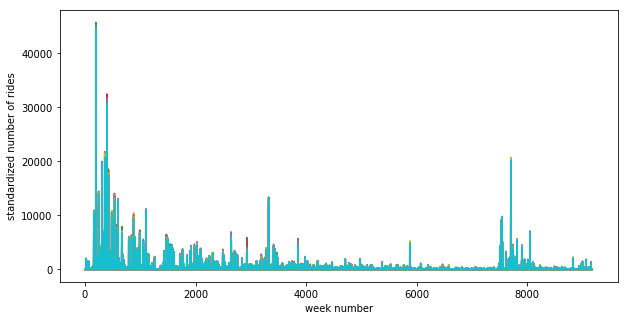

In [279]:
for i in range(10):
    pl.plot((mta_2d_w_df.reset_index().iloc[:,3:][i] - res_features['ts_mean']) / res_features['ts_stdev'])
pl.xlabel("week number")
pl.ylabel("standardized number of rides")

In [16]:
label = ...
label.shape

(9317,)

In [17]:
label[:26]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22,  0,  1,  2])

In [6]:
stationsmeans = ...
stationsmeans.shape

(600,)

In [7]:
stationsstd = ...
stationsstd.shape

(600,)

you will have to remove time series containing NaN because the random forest sklearn implementation does not work with NaNs. 
An easy way to do that is to remove all time series whose standard deviation is NaN
Here is how you would use to only extract station id for the valid (no containing nan) time series


In [10]:
stationid = np.concatenate([np.array([i] * 23) for i in range(600)])
stationid[mta.reshape(600*23, 194).std(1) > 0]

array([  0,   0,   0, ..., 550, 550, 550])

In [11]:
tots = mta.reshape....
tots.shape

(9317, 194)

In [13]:
normed_time_series_mean = ...
normed_time_series_std = ...

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.
//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


In [15]:
normed_time_series_std[:10]

[1.395418982736398,
 0.040502828714548786,
 0.005274169311689245,
 0.015024618528380378,
 0.010724532270930892,
 0.46734881809359824,
 0.7818394435461803,
 0.0013976175988299514,
 0.17261222074600674,
 0.07396098098064302]

In [18]:
tsmean = np.nanmean(tots, axis=1)
tsmean.shape



(9317,)

In [19]:
tsmean[:10]

array([5.79828866e+04, 1.80932474e+03, 2.34865979e+02, 7.30041237e+02,
       2.90108247e+02, 1.98267680e+04, 3.02422629e+04, 8.47422680e+00,
       9.67087629e+02, 4.26824742e+02])

In [93]:
tsstdev[:10]


array([18634.01356896,   540.86282986,    70.42970157,   200.63432488,
         143.21224115,  6240.83828981, 10440.45335489,    18.66337324,
        2305.01269034,   987.653128  ])

Text(0, 0.5, 'standardized number of rides')

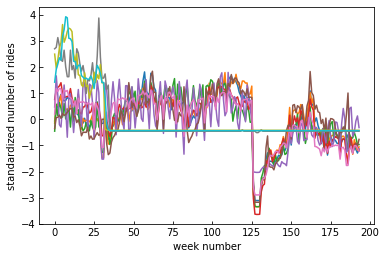

In [25]:
standardizedts = ...
for i in range(10):
    pl.plot(standardizedts[i])
pl.xlabel("week number")
pl.ylabel("standardized number of rides")

In [34]:
allfits = sm.OLS...
[a.params[0] for a in allfits[:10]]

[71890.84869151471,
 2091.2375892149093,
 282.7639968279143,
 915.9172085646317,
 407.4856463124503,
 21297.24948453608,
 41997.96748612212,
 29.473909595559086,
 3439.0558287073763,
 1505.7963521015074]

You can use the sklearn train_test_split() function to create your training and test dataset. 

In [98]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array([[a.params[0] for a in allfits], [a.params[1] for a in allfits], 
              np.mean(ts)/normedtsmean, np.std(ts)/normedtsstd]).T, 
    label, test_size=0.33, random_state=42, shuffle=True)

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [100]:
np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape

((6242, 4), (3075, 4), (6242,), (3075,))

depending on the details of your data processing you may have infinities as well. You also will have to get read of them

In [80]:
(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

(1, 0, 0, 0)

In [101]:
X_train[~np.isfinite(X_train)] = # ... make a choice about what to do with this datapoint. drop it or replace it with something

In [105]:
clf = rfc()...

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

and use sklearn confusion_matrix to see the errors

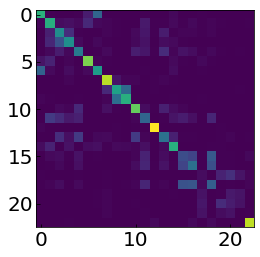

In [84]:
imshow(confusion_matrix(y_test, y_pred))

 and use classification_report to assess the model and clf.feature_importances_ to find the important features

## Build a model that uses as input features each time stamp (194 features) :


In [87]:
# use the same split ratio
X_train, X_test, y_train, y_test = train_test_split(
    ...

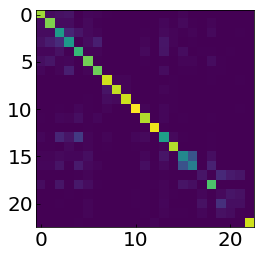

In [90]:
imshow(confusion_matrix(y_test, y_pred))

In [91]:
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.75      0.82      0.78       160
        14d       0.75      0.79      0.77       157
         1d       0.50      0.60      0.55       141
         2t       0.55      0.54      0.55       154
        30d       0.59      0.73      0.65       142
         7d       0.71      0.79      0.74       154
        ada       0.82      0.81      0.81       149
       afas       0.88      0.95      0.92       150
        exp       0.96      0.92      0.94       153
         ez       0.97      0.92      0.95       154
         ff       0.96      0.92      0.94       168
         mc       0.82      0.87      0.84       157
         mr       0.97      0.99      0.98       152
      month       0.57      0.55      0.56       159
        rfm       0.88      0.90      0.89       151
         rr       0.53      0.48      0.50       151
        sen       0.55      0.40      0.46       162
       spec       0.39      0.17      0.24   

Reference the FDNYdeaths.ipynb from Dr. Bianco's time series folder